In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="titanic.css">

# 機械学習によるデータ分析　ハンズオン

---

<br><br><br><br>
<div style="text-align:right;">
<!-- /h3>2018.mm.dd</h3 -->
<h4>auther</h4>
</div>

## 目的

- 例題を使って、機械学習によるデータ分析の手法を体験する
    - pythonによるデータ処理
        - データの調査
        - データの加工
        - ビジュアライズ(グラフ化)
        - 機械学習
        - etc.

## 題材：タイタニック号の生存者予測
1912年4月15日、氷山に衝突して沈没し 2224人の乗員乗客のうち1502人が亡くなった  
ある種の属性(女性、子供、一等船室、等)を持つ人々は生き延びやすかったとされている

### インプット
- 教師データ：生存結果ありの乗客リスト  
- テストデータ：生存結果なしの乗客リスト  

### 問題
***教師データから生存予測モデルを作り、テストデータの生存者を予測する***

### 出展
- Kaggleのチュートリアルコンペ (Titanic: Machine Learning from Disaster)
    - https://www.kaggle.com/startupsci/titanic-data-science-solutions

## データ分析の手順

1. Definition: 問題の定義
    - 何を求めたいのか？
        - クラス分類？／数値予測？
1. Feature Engineering: データを調査
    - 属性、値の範囲、欠損値の有無
    - 統計量（最大、最小、平均、中央、最頻、分散、etc.）  
    - 欠損値の扱い(補完／除外）
    - 数値化、正規化、標準化
    - 特徴選択
1. Model and Predict: モデル化し問題を解く
    - 機械学習アルゴリズムの選択
    - モデリング、データの学習
    - モデルの精度評価、パラメータチューニング
    - 分析結果

## Pythonでデータ分析するためのツール

### 環境
- 分析結果を確認しながら進める場合は、**jupyter notebook**がおすすめ

### Pythonパッケージ
- データ分析・加工
    - pandas (http://pandas.pydata.org/index.html)
    - numpy (https://docs.scipy.org/doc/numpy/)
- データのビジュアライズ
    - seaborn (https://seaborn.pydata.org/index.html)
    - matplotlib (https://matplotlib.org/)
- 機械学習
    - scikit-learn (http://scikit-learn.org/stable/index.html)

# Anaconda (https://www.anaconda.com/)
- 全部入っている

## モジュールをインポートする
- scikit-learnは後で使用するときにインポートする

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#インラインでデータフレームを表示させる
from IPython.core.display import display

# warning表示を抑止する
import warnings
warnings.filterwarnings('ignore')

# seabornのグラフの文字サイズを指定
sns.set_context('poster')

- %matplotlib inline は、notebook上にグラフ表示するためのおまじない

## Feature Engineering（特徴選択）

機械学習でよい結果を得るためには、どういうアルゴリズムでモデル化するかよりも、  
**<font color="red">どういうデータを使ってモデル化するか</font>**のほうが重要

- 感覚的には、データ分析タスクのうちの7割くらいは特徴選択にあたる
- データをモデル化するにあたり、データの内容を調査する
    - モデル化に使うデータ項目(特徴量)を選ぶ
    - 必要に応じて加工処理を施す

## データの前処理：4C

1. Correcting [修正・補正]
    - データをレビューし、明らかな誤りデータを修正・補正する
    - ex) 年齢＝800　→　80歳の誤りだろう
2. Completing [補完]
    - 欠損しているデータを妥当な値で補完する
    - ex) 平均値で補完、中央値で補完、他の特徴量から推定
3. Creating [作成]
    - 既存の特徴量から新たな特徴量を作り出す
    - ex) 名前から苗字を抽出する
4. Convertig [変換]
    - 文字データを数値データに変換
    - ex) 性別（男女）→　男性:0, 女性:1

In [3]:
# トレーニングデータ読み込み、サンプル確認
train_df = pd.read_csv('train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- データの参照や加工を容易に行うため、Pandas.DataFrame(Excelワークシートのイメージ)にデータを読み込む
- 項目の意味（わかりにくいもの）
    - Pclass : クラス（1st, 2nd, 3rd）
    - SibSp : 兄弟姉妹の人数、または、配偶者の人数
    - Parch : 親の人数、または、子供の人数
    - Ticket : チケット番号
    - Fare : 料金
    - Cabin : 客室番号（アルファベット＋数字）
    - Embarked : 乗船地（Southanpton, Cherbourg, Queenstown）

In [4]:
# トレーニングデータの件数、欠損、基本統計情報の確認
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Wick, Miss. Mary Natalie",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


- 特に、欠損のあるデータ（Age, Cabin, Embarked）をどう扱うか？

In [5]:
# テストデータ読み込み、サンプル確認
test_df = pd.read_csv('test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


- テストデータには**Survived**がない
    - これを予測するのが目的

In [6]:
# テストデータの件数、欠損、基本統計情報の確認
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Samaan, Mr. Hanna",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


- Age, Fare, Cabin に欠損がある
- 各データ項目の平均値などの基本統計情報はトレーニングデータと大体同じ

In [7]:
# トレーニングとテストのデータを結合する
# 特徴量の加工操作には、一括で扱うのが楽
combined = pd.concat([train_df, test_df]).reset_index(drop=True)
original_features = combined.columns.tolist()   # もともとの項目をとっておく
combined[888:894]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
888,NaN,NaN,S,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,female,1,0.0,W./C. 6607
889,26.0,C148,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369
890,32.0,NaN,Q,7.7500,"Dooley, Mr. Patrick",0,891,3,male,0,0.0,370376
891,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
892,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272
893,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276


# それぞれの項目（特徴量）を個別に見ていきます

## Pclass
- 欠損なし
- 各クラスの件数と生存率との関連を可視化してみる
    - seabornを使用すると、きれいなグラフが簡単に作成できる

In [8]:
# 件数確認
# プレゼンの見た目をそろえるためにDataFrameにしているが、
# train_df.Pclass.value_counts() だけでよい
pd.DataFrame(train_df.Pclass.value_counts())

,Pclass
3,491
1,216
2,184


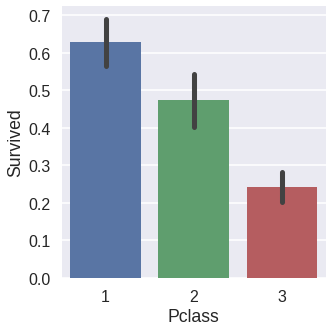

In [9]:
# Pclassごとの生存率
sns.factorplot(data=combined[0:891], x='Pclass', y='Survived', kind='bar', size=5)

- クラスによって生存率に差がみられる
    - 1st > 2nd > 3rd

### Pclassの値は何なのか？
- 1～3の値をとる数値（量的なデータ）
- クラスのカテゴリ（質的なデータ）

### どちらの解釈でもよい
- 分析手法(機械学習アルゴリズム)や分析結果を見て決めてもよい（と思う）

ここでは、質的データとして扱うので、**<font color="red">ダミー変数</font>**に変換する

In [10]:
# Pclassをダミー変数に展開
combined = pd.concat([combined, pd.get_dummies(combined['Pclass'], prefix='Pclass')], axis=1)

# 特徴リストに追加しておく（後で使うため）
features  = ['Pclass_1', 'Pclass_2', 'Pclass_3']
 
combined[['Pclass', 'Pclass_1', 'Pclass_2', 'Pclass_3']].head()

,Pclass,Pclass_1,Pclass_2,Pclass_3
0,3,0,0,1
1,1,1,0,0
2,3,0,0,1
3,1,1,0,0
4,3,0,0,1


## Parch
- 欠損なし
- 生存率との関係を見てみる

In [11]:
# Parchの度数分布を確認
display(pd.DataFrame(combined.Parch.value_counts()))

# 特徴リストに追加しておく
features.append('Parch')

,Parch
0,1002
1,170
2,113
3,8
5,6
4,6
9,2
6,2


- 3以上は件数が少ない

- Parchごとの生存率をグラフ化

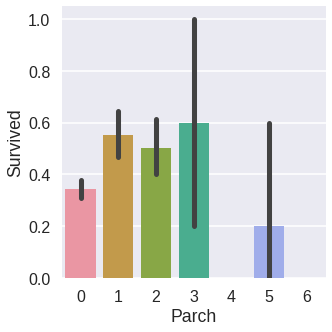

In [12]:
# Parchごとの生存率
sns.factorplot(data=combined[0:891], x='Parch', y='Survived', kind='bar', size=5)

- 3以上は、ばらつき（95%信頼区間）も大きい
- 0 / 1～2 / 3以上　というようにカテゴリ分割することも考えられる
- ここでは、このまま扱うこととする

## SibSp
- 欠損なし
- 生存率との関係を見てみる

In [13]:
# SibSpの度数分布を確認
display(pd.DataFrame(combined.SibSp.value_counts()))

# 特徴リストに追加しておく
features.append('SibSp')

,SibSp
0,891
1,319
2,42
4,22
3,20
8,9
5,6


- 0と1に集中している

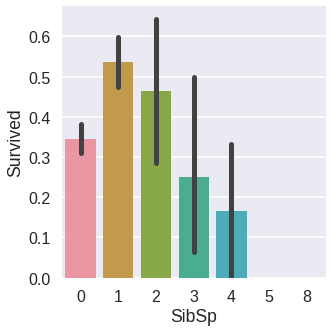

In [14]:
# SibSpごとの生存率
sns.factorplot(data=combined[0:891], x='SibSp', y='Survived', kind='bar', size=5)

- 度数分布に偏りがある、2以上はばらつきも大きいなどから、カテゴリ分割することも考えられる
- ここでは、このまま扱うこととする

## FamilySize
- ParchとSibSPから新しい特徴量 **FamilySize** (家族の人数)を作る
- 家族単位で行動すると思われるので、人数が多いほど避難が困難となるのでは？という考え

In [15]:
# FamilySize
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# 度数分布 
pd.DataFrame(combined.FamilySize.value_counts())

,FamilySize
1,790
2,235
3,159
4,43
6,25
5,22
7,16
11,11
8,8


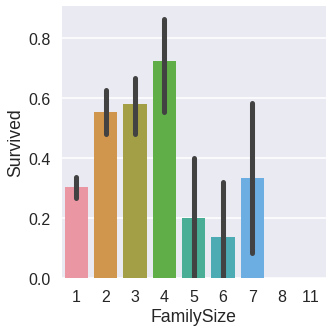

In [16]:
# FamilySizeと生存率
sns.factorplot(data=combined[:891], x='FamilySize', y='Survived', kind='bar', size=5)

- 1 / 2～4 / 5～ でグループに分かれているように見える
- この3つのカテゴリに分割する

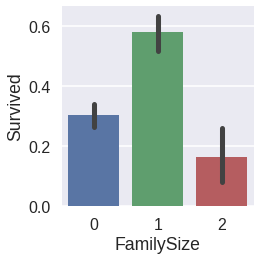

In [17]:
# FamilySizeを1, 2-4, 5- の3カテゴリに分類
combined['FamilySize'] = pd.cut(combined['FamilySize'], bins=[0, 1, 4, 15], labels=[0, 1, 2])

# ダミー変数化して特徴リストに追加
combined = pd.concat([combined, pd.get_dummies(combined['FamilySize'], prefix='FamilySize')], axis=1)
features.extend(['FamilySize_0', 'FamilySize_1', 'FamilySize_2'])

# FamilySizeと生存率
sns.factorplot(data=combined[:891], x='FamilySize', y='Survived', kind='bar', size=4)

- 単身者よりも少人数の家族のほうが有利
- 大家族は圧倒的に不利

## Sex
- 欠損なし

In [18]:
# 度数分布を確認
display(pd.DataFrame(combined.Sex.value_counts()))

# ダミー変数に変換
combined = pd.concat([combined, pd.get_dummies(combined['Sex'])], axis=1)

# 特徴リストに追加
features.extend(['male', 'female'])

,Sex
male,843
female,466


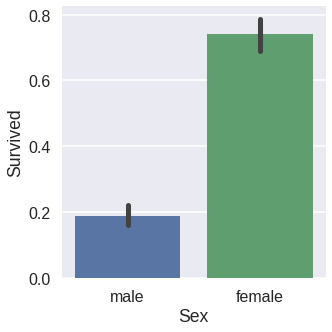

In [19]:
# 性別ごとの生存率
sns.factorplot(data=combined[0:891], x='Sex', y='Survived', kind='bar', size=5)

- 女性のほうが圧倒的に生存している

## Embarked
- 欠損あり（2件）

In [20]:
# 欠損データ確認
combined[combined.Embarked.isnull()][original_features]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [21]:
# CabinとTicketが同じなので、同乗者と推測
# Pclass=1かつ Fare±10% (価格が近い)かつ CabinがBのEmbarkedの値を確認
combined.loc[(combined.Pclass == 1) & (72. < combined.Fare) & 
             (combined.Fare < 88.) & (combined.Cabin.str.contains('B')) &
             combined.Embarked.notnull(), 'Embarked'].value_counts()

S    5
C    4
Name: Embarked, dtype: int64

- SともCとも判断つかないので、元データを確認してみる

In [22]:
# データを見てみる
combined.loc[(combined.Pclass == 1) & (72. < combined.Fare) & 
             (combined.Fare < 88.) & (combined.Cabin.str.contains('B')) &
             combined.Embarked.notnull(), original_features].sort_values(by='Ticket')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
257,30.0,B77,S,86.5000,"Cherry, Miss. Gladys",0,258,1,female,0,1.0,110152
504,16.0,B79,S,86.5000,"Maioni, Miss. Roberta",0,505,1,female,0,1.0,110152
759,33.0,B77,S,86.5000,"Rothes, the Countess. of (Lucy Noel Martha Dye...",0,760,1,female,0,1.0,110152
587,60.0,B41,C,79.2000,"Frolicher-Stehli, Mr. Maxmillian",1,588,1,male,1,1.0,13567
1288,48.0,B41,C,79.2000,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",1,1289,1,female,1,NaN,13567
903,23.0,B45,S,82.2667,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",0,904,1,female,1,NaN,21228
1178,24.0,B45,S,82.2667,"Snyder, Mr. John Pillsbury",0,1179,1,male,1,NaN,21228
139,24.0,B86,C,79.2000,"Giglio, Mr. Victor",0,140,1,male,0,0.0,PC 17593
789,46.0,B82 B84,C,79.2000,"Guggenheim, Mr. Benjamin",0,790,1,male,0,0.0,PC 17593


- S、Cどちらもありえそうなので、全体で多いほうで補完する

In [23]:
# 度数分布確認
pd.DataFrame(combined.Embarked.value_counts())

,Embarked
S,914
C,270
Q,123


- Sで補完し、ダミー変数に変換する
- 生存率を見てみる

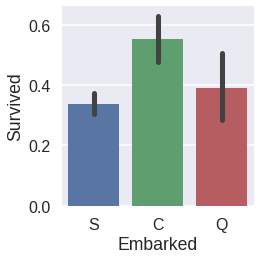

In [24]:
# Embarked = S で補完
combined['Embarked'] = combined['Embarked'].fillna('S')

# ダミー変数に変換、特徴リストに追加
combined = pd.concat([combined, pd.get_dummies(combined['Embarked'], prefix='Embarked')], axis=1)
features.extend(['Embarked_S', 'Embarked_Q', 'Embarked_C'])

# 生存率
sns.factorplot(data=combined[0:891], x='Embarked', y='Survived', kind='bar', size=4)

## Fare
- 欠損あり（1件）

In [25]:
# 欠損データ確認
combined[combined.Fare.isnull()][original_features]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


- 料金が決まる要素として考えられるもの
    - クラス
    - 距離（乗船地）
    - 人数

- Pclass, Embarked, Parch, SibSpが同じデータの平均値で補完

In [26]:
fare_mean = combined[(combined.Pclass == 3) & (combined.Embarked == 'S') &
                    (combined.Parch == 0) & (combined.SibSp == 0)].Fare.mean()
combined['Fare'].fillna(fare_mean, inplace=True)

# 特徴リストに追加
features.append('Fare')

# 確認
combined[combined.PassengerId == 1044][original_features]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,9.593713,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


- 料金帯ごとの生存者数・死亡者数をヒストグラムで可視化
    - seabornだと積上げヒストグラムが描けないので、matplotlibで描いてみる

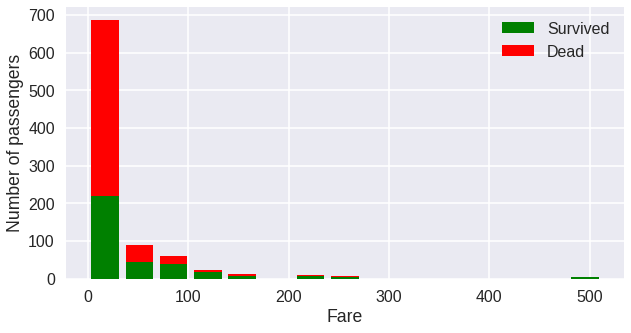

In [27]:
# 料金を15階級に均等分割してヒストグラムを作成
data = combined[:891]
fig = plt.figure(figsize=(10,5))
plt.hist([data[data['Survived']==1]['Fare'], data[data['Survived']==0]['Fare']],
         stacked=True, bins=15, label=['Survived', 'Dead'], rwidth=0.8, color=['g', 'r'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

## Name
名前を処理して新たな特徴量を作り出す
- Title(敬称)を抽出し特徴量とする
    - 性別・年齢・身分などを表しているので、生死に関連すると思われる
- NameLength(名前の長さ)を特徴量とする
    - 長い名前は、女性(旧姓が書いてある)や高貴な人の可能性が高い

### Title

In [28]:
# Titleを抽出
combined['Title'] = combined.Name.str.extract('([A-Za-z]+)\.')

# Titleの男女構成（クロス集計）
pd.crosstab(combined['Sex'], [combined['Title']])

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


- 人数の少ないTitleが結構ある

In [29]:
# Titleをカテゴリ変換
# 数の少ない(1桁)TitleをOtherにまとめる
# Mlle(マドモワゼル)⇒Miss, Mme(マダム)⇒Mrs, Ms⇒Miss
title_dict = {
    'Capt': 'Other', 'Col': 'Other', 'Countess': 'Other', 'Don': 'Other', 'Dona': 'Other', 'Dr': 'Other',
    'Jonkheer': 'Other', 'Lady': 'Other', 'Major': 'Other', 'Master': 'Master', 'Miss': 'Miss',
    'Mlle': 'Miss', 'Mme': 'Mrs', 'Mr': 'Mr', 'Mrs': 'Mrs', 'Ms': 'Miss', 'Rev': 'Other', 'Sir': 'Other'}

combined['TitleCat'] = combined.Title.map(title_dict)

# TitleCatの男女構成  
pd.crosstab(combined['Sex'], combined['TitleCat'])

TitleCat,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


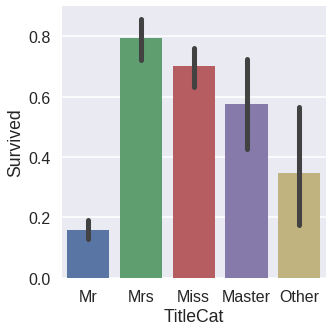

In [30]:
# TitleCatごとの生存率
sns.factorplot(data=combined[:891], x='TitleCat', y='Survived', kind='bar', size=5)

In [31]:
# Otherは数が少なく、ばらつきも大きいので、性別に応じてMr/Mrsに振り分ける
combined.loc[(combined.TitleCat == 'Other') & (combined.Sex == 'male'), 'TitleCat'] = 'Mr'
combined.loc[(combined.TitleCat == 'Other') & (combined.Sex == 'female'), 'TitleCat'] = 'Mrs'

# ダミーに変換、特徴リストに追加
combined = pd.concat([combined, pd.get_dummies(combined['TitleCat'], prefix='TitleCat')], axis=1)
features.extend(['TitleCat_Mr', 'TitleCat_Mrs', 'TitleCat_Miss', 'TitleCat_Master'])

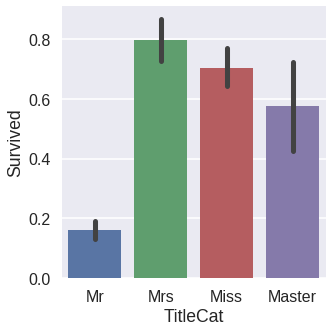

In [32]:
# TitleCatごとの生存率
sns.factorplot(data=combined[:891], x='TitleCat', y='Survived', kind='bar', size=5)

### NameLength

In [33]:
# NameLength
combined['NameLength'] = combined['Name'].apply(lambda x: len(x))
features.append('NameLength')

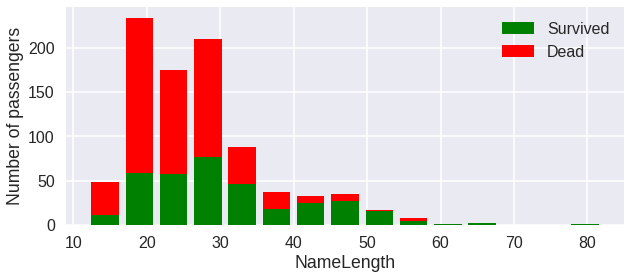

In [34]:
# NameLengthとSurvivedの関係を積上げヒストグラムで可視化
data = combined[:891]
fig = plt.figure(figsize=(10,4))
plt.hist([data[data['Survived']==1]['NameLength'], data[data['Survived']==0]['NameLength']],
         stacked=True, bins=15, label=['Survived', 'Dead'], rwidth=0.8, color=['g', 'r'])
plt.xlabel('NameLength')
plt.ylabel('Number of passengers')
plt.legend()

## Cabin
- 欠損が多い 
    - 欠損データ数:1014 / 全データ数:1309
    - 対応をどうするかは、データを見て決める
- Cabin番号のフォーマット
    - アルファベット1文字＋数字

In [35]:
# Cabinの頭文字を確認
pd.DataFrame(combined.Cabin.str[0].value_counts(dropna=False).sort_index()).T

,A,B,C,D,E,F,G,T,nan
Cabin,22,65,94,46,41,21,5,1,1014


In [36]:
# NaNをZにする
combined['Cabin'] = combined.Cabin.fillna('Z')
pd.DataFrame(combined.Cabin.str[0].value_counts(dropna=False).sort_index()).T

,A,B,C,D,E,F,G,T,Z
Cabin,22,65,94,46,41,21,5,1,1014


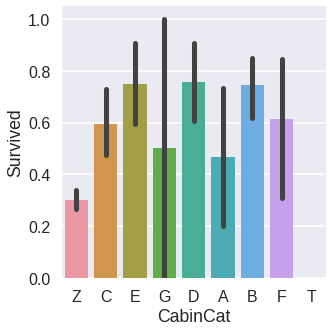

In [37]:
# CabinCat=Cabinの先頭文字
combined['CabinCat'] = combined['Cabin'].str[0]

# CabinCatごとの生存率
sns.factorplot(data=combined[:891], x='CabinCat', y='Survived', kind='bar', size=5)

- B, D, E については、生存率は高いと言えそう
- A, F, G, T は、度数が少なく、ばらつきも大きいので、なんとも言えない
- Cabinが不明(Z)だと生存率が低いということは言えそう

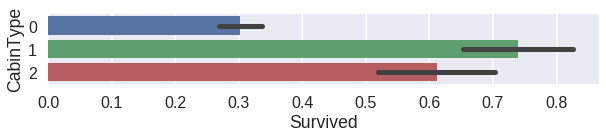

In [38]:
# Cabinの数字部分：偶数/奇数が右舷/左舷に該当していた
import re

def get_type(cabin):
    cabin_search = re.search('\d+', cabin)
    if cabin_search:
        num = cabin_search.group(0)
        if int(num) % 2 == 0:
            return 2
        else:
            return 1
    return 0

combined['CabinType'] = combined['Cabin'].apply(get_type)

# CabinTypeごとの生存率
sns.factorplot(data=combined[:891], x='Survived', y='CabinType', kind='bar', orient='h', size=2.2, aspect=4)

- 奇数番号の客室のほうが若干生存率が良い

### CabinCatもCabinTypeも特徴量としておく
- Survibedとの関連はありそう
- あとで除外することもできる

In [39]:
# ダミー変数化、特徴リストへ追加
combined = pd.concat([combined, pd.get_dummies(combined['CabinCat'], prefix='CabinCat')], axis=1)
features.extend(['CabinCat_A', 'CabinCat_B', 'CabinCat_C', 'CabinCat_D',
                       'CabinCat_E', 'CabinCat_F', 'CabinCat_G', 'CabinCat_T', 'CabinCat_Z'])
combined = pd.concat([combined, pd.get_dummies(combined['CabinType'], prefix='CabinType')], axis=1)
features.extend(['CabinType_0', 'CabinType_1', 'CabinType_2'])

## Age
- 欠損が多い
    - 欠損データ数:263 / 全データ数:1309
- 年齢は重要な要素と思われるので補完したい

,count,mean,std,min,25%,50%,75%,max
Age,1046.0,29.881138,14.413493,0.17,21.0,28.0,39.0,80.0


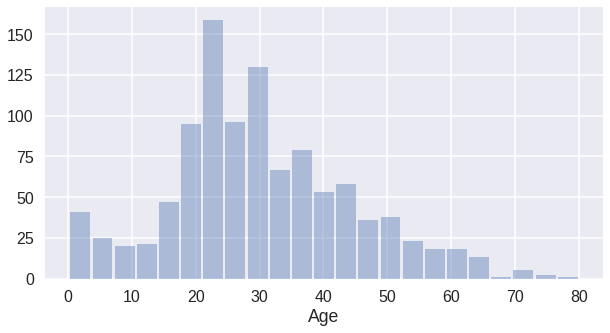

In [40]:
# 欠損補完前のAgeの分布を確認する
age_before = pd.DataFrame(combined.describe().Age)
display(age_before.T)
plt.figure(figsize=(10,5))
sns.distplot(combined.loc[combined.Age.notnull(), 'Age'], kde=False, norm_hist=False, hist_kws={'rwidth':0.9})

In [41]:
# 欠損値を推定するのに有用な特徴量を見定めるため、
# Ageとの相関係数を確認する
age_corr = combined[combined.Age.notnull()].corr().Age
age_corr_df = pd.DataFrame(age_corr)

# 相関係数の絶対値 > 0.2を表示
age_corr_df[(age_corr_df.Age < -0.2) | (age_corr_df.Age > 0.2)].sort_values(by='Age')

,Age
Pclass,-0.408106
TitleCat_Master,-0.391259
Pclass_3,-0.337069
CabinType_0,-0.290117
CabinCat_Z,-0.289740
TitleCat_Miss,-0.282792
SibSp,-0.243699
TitleCat_Mrs,0.222737
CabinType_1,0.226970
TitleCat_Mr,0.236030


In [42]:
# ExtraTreesRegressorで年齢を推定する
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=200, random_state=0)

# 相関係数の絶対値>0.2の特徴量を使用して推定する
estimate_features = ['TitleCat_Master', 'Pclass_3', 'CabinType_0', 'CabinCat_Z', 'TitleCat_Miss', 'SibSp',
                    'Pclass_1', 'TitleCat_Mr', 'CabinType_1', 'TitleCat_Mrs']
# 教師データ
X_train = combined.loc[combined.Age.notnull(), estimate_features]
Y_train = combined.Age.dropna()

# テストデータ
X_test = combined.loc[combined.Age.isnull(), estimate_features]

# 学習
etr.fit(X_train, Y_train)

# 推定
pred = etr.predict(X_test)

# 推定値で欠損値を補完
combined.loc[combined.Age.isnull(), 'Age'] = pred

# 特徴リストに追加
features.append('Age')

In [43]:
# 欠損補完後のAgeの分布
print("after completing")
display(pd.DataFrame(combined.describe().Age).T)
print("-" * 50)
print("before completing")
display(age_before.T)

after completing


,count,mean,std,min,25%,50%,75%,max
Age,1309.0,29.54574,13.482821,0.17,21.257576,28.741176,36.5,80.0


--------------------------------------------------
before completing


,count,mean,std,min,25%,50%,75%,max
Age,1046.0,29.881138,14.413493,0.17,21.0,28.0,39.0,80.0


- 平均値や標準偏差等、大きく変わらないように補完できている

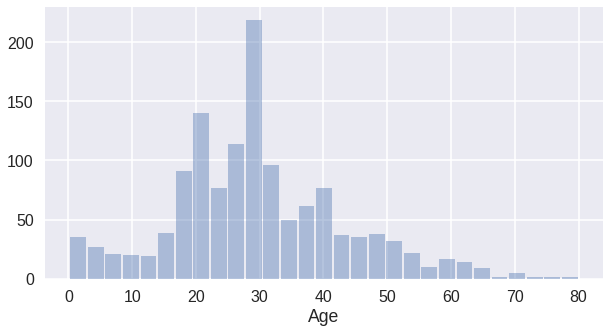

In [44]:
# 欠損補完後のAgeの分布
plt.figure(figsize=(10,5))
sns.distplot(combined['Age'], kde=False, norm_hist=False, hist_kws={'rwidth':0.9})

- 分布の形状も、補完前と大きくは変わっていない

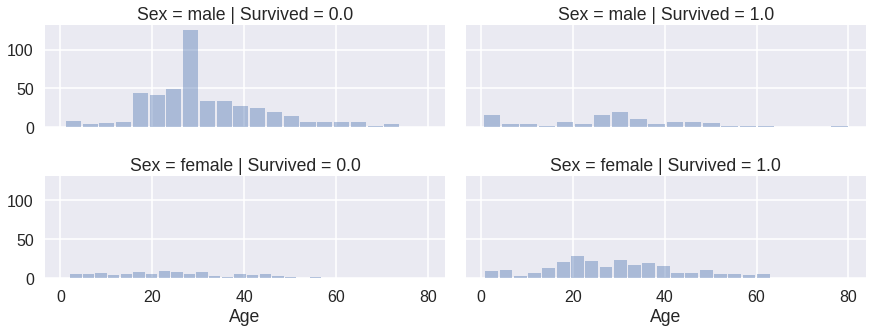

In [45]:
# 年齢、性別による生存率
grid = sns.FacetGrid(combined[0:891], col='Survived', row='Sex', size=2.5, aspect=2.5)
grid.map(sns.distplot, 'Age', kde=False, norm_hist=False, hist_kws={'rwidth':0.9}, bins=20)

- 10代後半以上の男性の生存率はかなり低い
- 女性はどの年代でも生存率は高め
- 10代前半以下では男女の差はあまりない

## person
- child / male_adult / female_adult に分類する
  - 子供は男女差が小さいため

In [46]:
# 子供の年齢をいくつにするか？
# Title=Masterの年齢を確認
pd.DataFrame(combined.loc[combined.Title == 'Master', 'Age'].sort_values(ascending=False).head())

,Age
1251,14.5
159,14.5
1283,13.0
1045,13.0
955,13.0


In [47]:
# 15歳未満を子供とする
child_age = 15

def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female' ):
        return 'female_adult'
    else:
        return 'male_adult'

#各行に対して関数を適用し、personの値を求める
combined['person'] = combined[['Age', 'Sex']].apply(get_person, axis=1)

# ダミー変数化
combined = pd.concat([combined, pd.get_dummies(combined['person'])], axis=1)
features.extend(['child', 'male_adult', 'female_adult'])
combined[['Age', 'Sex', 'person', 'child', 'male_adult', 'female_adult']].head()

,Age,Sex,person,child,male_adult,female_adult
0,22.0,male,male_adult,0,1,0
1,38.0,female,female_adult,0,0,1
2,26.0,female,female_adult,0,0,1
3,35.0,female,female_adult,0,0,1
4,35.0,male,male_adult,0,1,0


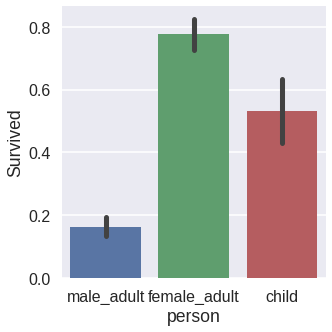

In [48]:
# person の生存率
sns.factorplot(data=combined[:891], x='person', y='Survived', kind='bar', size=5)

- 成人男性の生存率はかなり低い
- 成人女性の生存率は高め
- 子供の生存率は約50%

## Ticket
- 欠損なし
- 重複のあるデータ
    - 同じチケット番号＝同じグループ
    - 同じグループには、家族も含まれている
    - 緊急時には、グループ単位・家族単位で行動するはず

In [49]:
# 同じチケット番号は同じグループとし、チケットごとに人数を集計
ticket = pd.DataFrame(combined.Ticket.value_counts())

# カラム名変更 Ticket -> TicketMembers
ticket.rename(columns={'Ticket':'TicketMembers'}, inplace=True)
ticket.head()

,TicketMembers
CA. 2343,11
CA 2144,8
1601,8
347082,7
347077,7


,1,2,3,4,5,7,6,8,11
TicketMembers,713,132,49,16,7,5,4,2,1


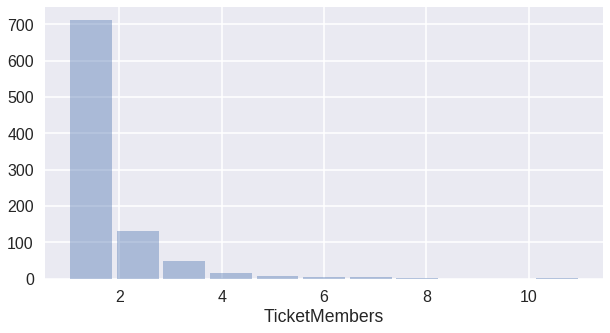

In [50]:
# TicketMembersごとの度数分布を確認する
display(pd.DataFrame(ticket.TicketMembers.value_counts()).T)
plt.figure(figsize=(10,5))
sns.distplot(ticket.TicketMembers, kde=False, norm_hist=False, bins=11, hist_kws={'rwidth':0.9})

In [51]:
# チケットメンバーをいったんcombinedにマージ
combined = pd.merge(combined, ticket, left_on='Ticket', right_index=True, how='left')

# 同一チケットグループ(2名以上)で成人女性の死亡者有無をフラグ化
# グループ内の成人女性が死亡していれば、他のメンバーも助かっていない確率が高いと想定
ticket['Ticket_perishing_women'] = combined.Ticket[(combined.female_adult == 1)
                                                   & (combined.Survived == 0.0)
                                                   & (combined.TicketMembers > 1)].value_counts()
ticket['Ticket_perishing_women'] = ticket['Ticket_perishing_women'].fillna(0)
ticket.loc[ticket.Ticket_perishing_women > 0, 'Ticket_perishing_women'] = 1

# 同一チケットグループ(2名以上)で成人男性の生存者有無をフラグ化
# グループ内の成人男性が生存していれば、他のメンバーも助かっている確率が高いと想定
ticket['Ticket_surviving_men'] = combined.Ticket[(combined.male_adult == 1)
                                                 & (combined.Survived == 1.0)
                                                 & (combined.TicketMembers > 1)].value_counts()
ticket['Ticket_surviving_men'] = ticket['Ticket_surviving_men'].fillna(0)
ticket.loc[ticket.Ticket_surviving_men > 0, 'Ticket_surviving_men'] = 1

# TicketMembersをカテゴリ分類（FamilySizeと同様）
ticket['TicketMembers'] = pd.cut(ticket['TicketMembers'], bins=[0,1,4,15], labels=[0,1,2])

# combinedから、いったん追加したTicketMembersを削除
combined.drop(['TicketMembers'], inplace=True, axis=1)

# チケット関連データをマージ
combined = pd.merge(combined, ticket, left_on='Ticket', right_index=True, how='left')

# ダミー変数化、特徴リストに追加
combined = pd.concat([combined, pd.get_dummies(combined.TicketMembers, prefix='TicketMembers')], axis=1)
features.extend(['TicketMembers_0', 'TicketMembers_1', 'TicketMembers_2',
                       'Ticket_perishing_women', 'Ticket_surviving_men'])

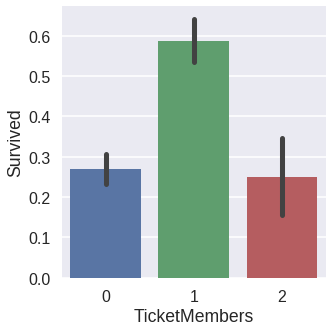

In [52]:
# 生存率
sns.factorplot(data=combined, x='TicketMembers', y='Survived', kind='bar', size=5)

### 家族単位に、TIcketグループと同様の特徴量を求める

In [53]:
# 家族＝Surnameの処理
# 同姓を区別するため、チケット番号をつける
def get_surname(row):
    name, ticket = row
    surname = name.split(',')[0].lower()
    return '{0}_{1}'.format(surname, ticket)

combined['Surname'] = combined[['Name', 'Ticket']].apply(get_surname, axis=1)

surname = pd.DataFrame(combined['Surname'].value_counts())
surname.rename(columns={'Surname':'SurnameMembers'}, inplace=True)
surname.head()

,SurnameMembers
sage_CA. 2343,11
goodwin_CA 2144,8
andersson_347082,7
asplund_347077,7
skoog_347088,6


,1,2,3,4,6,5,7,11,8
SurnameMembers,848,117,38,9,4,4,2,1,1


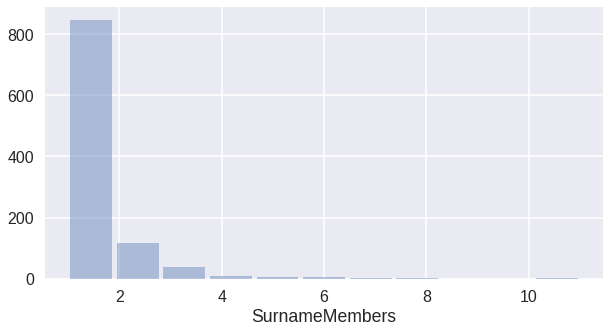

In [54]:
# SurnameMembersごとの度数分布を確認する
display(pd.DataFrame(surname.SurnameMembers.value_counts()).T)
plt.figure(figsize=(10,5))
sns.distplot(surname.SurnameMembers, kde=False, norm_hist=False, bins=11, hist_kws={'rwidth':0.9})

In [55]:
# Surnameメンバーをいったんcombinedにマージ
combined = pd.merge(combined, surname, left_on='Surname', right_index=True, how='left')

# 同一Surnameの家族(2名以上)内で成人女性の死亡者有無をフラグ化
surname['Surname_perishing_women'] = combined.Surname[(combined.female_adult == 1)
                                                  & (combined.Survived == 0.0)
                                                  & (combined.SurnameMembers > 1)].value_counts()
surname['Surname_perishing_women'] = surname['Surname_perishing_women'].fillna(0)
surname.loc[surname.Surname_perishing_women > 0, 'Surname_perishing_women'] = 1

# 同一Surnameの家族(2名以上)内で成人男性の生存者有無をフラグ化
surname['Surname_surviving_men'] = combined.Surname[(combined.male_adult == 1)
                                                  & (combined.Survived == 1.0)
                                                  & (combined.SurnameMembers > 1)].value_counts()
surname['Surname_surviving_men'] = surname['Surname_surviving_men'].fillna(0)
surname.loc[surname.Surname_surviving_men > 0, 'Surname_surviving_men'] = 1

# カテゴリ分類、FamilySizeと同様
surname['SurnameMembers'] = pd.cut(surname['SurnameMembers'], bins=[0,1,4,15], labels=[0,1,2])

# combinedから、いったん追加したSurnameMembersを削除
combined.drop(['SurnameMembers'], inplace=True, axis=1)

# マージ
combined = pd.merge(combined, surname, left_on='Surname', right_index=True, how='left', sort=False)

# ダミー変数化、特徴リストに追加
combined = pd.concat([combined, pd.get_dummies(combined.SurnameMembers, prefix='SurnameMembers')], axis=1)
features = features + ['SurnameMembers_0', 'SurnameMembers_1', 'SurnameMembers_2',
                       'Surname_perishing_women', 'Surname_surviving_men']

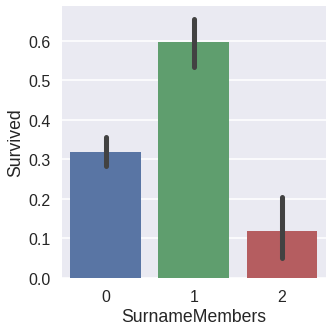

In [56]:
# 生存率
sns.factorplot(data=combined, x='SurnameMembers', y='Survived', kind='bar', size=5)

# 機械学習で生存者を予測する

## データセットを作成する

In [57]:
# トレーニングデータ、ターゲットデータ、テストデータを生成
train = combined[0:891][features].copy()
target = combined[0:891]['Survived'].copy()
test = combined[891:][features].copy()

# 特徴量の数(次元数)を確認する
print('number of features = {}'.format(train.shape[1]))

number of features = 45


## 次元の呪い

データの次元数(パラメータ数)が大きくなりすぎると、そのデータで表現できる組み合わせが飛躍的に多くなってしまい、手元にある有限なサンプルデータでは十分な学習結果が得られなくなる

### 次元の呪いを回避するには？
- 特徴選択
    - 特徴量の中から必要なものを選ぶ
- 次元削減
    - 本来の情報量を維持したまま低次元データに変換する
    - よく知られているのは、主成分分析(PCA)

### ここでは特徴選択を行ってみる
- SelectKBestを使用
    - 各特徴量ごとに分類に対する寄与度を求めることができる

In [58]:
# 特徴量の分類に対する寄与度を調査する
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(k='all')
selector.fit(train, target)

SelectKBest(k='all', score_func=<function f_classif at 0x7efc233acd08>)

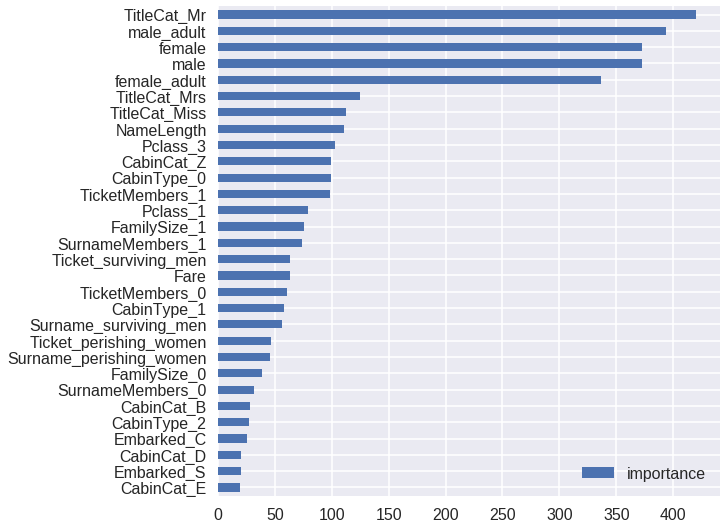

In [59]:
# 寄与度の大きい特徴Top30をグラフ化
importance = pd.DataFrame({'importance': selector.scores_}, index=features)
importance.sort_values(by=['importance'], ascending=True, inplace=True)
importance[importance.importance.notnull()].tail(30).plot(kind='barh', figsize=(9,9))

In [60]:
# 上位の特徴を選択
selected_features = importance[importance.importance.notnull()].tail(25).index.tolist()
print('features: {}'.format(selected_features))

features: ['CabinCat_B', 'SurnameMembers_0', 'FamilySize_0', 'Surname_perishing_women', 'Ticket_perishing_women', 'Surname_surviving_men', 'CabinType_1', 'TicketMembers_0', 'Fare', 'Ticket_surviving_men', 'SurnameMembers_1', 'FamilySize_1', 'Pclass_1', 'TicketMembers_1', 'CabinType_0', 'CabinCat_Z', 'Pclass_3', 'NameLength', 'TitleCat_Miss', 'TitleCat_Mrs', 'female_adult', 'male', 'female', 'male_adult', 'TitleCat_Mr']


# 機械学習による分析

### 1. トレーニングデータから機械学習分類器(モデル)を作成

### 2. モデルの評価・パラメータチューニング

### 3. 作成したモデルでテストデータを推定

## 1. モデルの作成

- 機械学習アルゴリズムを選択する
    - 今回の問題では、クラス分類のアルゴリズムを使用する
- scikit-learnのAPIは、どのアルゴリズムでも基本的なインタフェースは統一されている
    - fit: トレーニングデータでモデルを学習させる
    - predict: 学習したモデルでテストデータを分析・推定する
    - transform: データを変換する

## 2. モデルの評価・パラメータチューニング

### クロスバリデーション（評価）
- 分類器を評価するためには、学習用データとは異なるテストデータの分析結果の正解率を見るのが理想
- しかし、テストデータには正解のラベルがない
- ラベル付の学習データを、学習用とテスト用に分割して評価する
    - K分割して、学習分とテスト分を入れ替えながらK回評価して、平均をとる

### グリッドサーチ（パラメータチューニング）
- パラメータの設定範囲を指定することで、最適なパラメータの組を探索する方法

### 参考：いろいろな評価指標
FPR以外は、1に近いほど分類器の性能が良いといえる

|指標|意味|計算式|
|:---|:---|:---|
|Accuracy|正解率。予測結果が実際の値とどれくらい一致しているか|(TP+TN) / (TP+FP+FN+TN)|
|Precision|適合率。予測が真と判定したもので、実際の値が真のもの|TP / (TP+FP)|
|Recall|再現率。実際の値が真のうち、予測が真のもの|TP / (TP+FN)|
|F値|予測精度の評価指標。PrecisionとRecallの調和平均|(2 x Precision x Recall) / (Precision + Recall)|
|TPR(True Positive Rate)|真陽性率。Recallと同じ|TP / (TP+FN)|
|FPR(False Positive Rate)|偽陽性率。実際の値が偽のうち、予測が真のもの|FP / (FP+TN)|
|ROC曲線|Receiver Operating Characteristic. 縦軸にTPR、横軸にFPRをプロット|-|
|AUC|Area Under the Curve. ROC曲線の曲線より下側の面積。分類器の精度評価に使う。|-|

- TP/FP/TN/FN

|-|実際の値=1|実際の値=0|
|:---|:---|:---|
|***予測値=1***|True Positive(TP)|False Positive(FP)|
|***予測値=0***|False Negative(FN)|True Negative(TN)|

In [61]:
# 分類器アルゴリズム(比較用も含む)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# クロスバリデーション/グリッドサーチ用
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 事前処理用(正規化、パイプライン処理)
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# クロスバリデーション用データ分割を定義
cv_split = StratifiedKFold(n_splits=3, random_state=0)

In [62]:
# アルゴリズムの比較対象
# ハイパーパラメータは基本的にデフォルトで実施(乱数のみ固定化)
classifiers = [
    RandomForestClassifier(random_state=0, n_estimators=1000),
    AdaBoostClassifier(random_state=0, n_estimators=1000),
    GradientBoostingClassifier(random_state=0, n_estimators=1000),
    SVC(random_state=0),
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(random_state=0)
]

# 選択した特徴を使用する
X_train = train[selected_features]

In [63]:
# 評価結果格納用のデータフレーム
results = pd.DataFrame()

# 各アルゴリズムのaccuracyを求める
for clf in classifiers:
    name = clf.__class__.__name__
    # データの正規化(0～1の範囲に変換)を施してから機械学習をする(パイプラインを使用)
    pl = Pipeline([('preprocess', MinMaxScaler()), ('clf', clf)])
    # クロスバリデーション
    # ※グリッドサーチのパラメータを空にして、クロスバリデーションのみ実施している
    gscv = GridSearchCV(pl, scoring='accuracy', param_grid={}, cv=cv_split, n_jobs=8)
    gscv.fit(X_train, target)
    results = results.append(pd.DataFrame([gscv.best_score_], index=[name]))

# 結果表示
results.columns = ['accuracy']
results.sort_values(by='accuracy', ascending=False)

,accuracy
LogisticRegression,0.882155
SVC,0.872054
KNeighborsClassifier,0.865320
RandomForestClassifier,0.863075
GradientBoostingClassifier,0.861953
AdaBoostClassifier,0.848485
DecisionTreeClassifier,0.832772
GaussianNB,0.812570


In [64]:
# 指定したモデルとパラメータでグリッドサーチ＆クロスバリデーションして
# ベストパラメータでテストデータの予測をして予測結果を返す
def run_predict(clf, params, current_features):
    # トレーニングデータ
    X = train[current_features]

    # 正規化を実施するパイプライン
    pl = Pipeline([('preprocess', MinMaxScaler()), ('clf', clf)])
    
    # パラメータ名の接頭辞変換(パイプライン対応)
    new_params = {}
    for k, v in params.items():
        new_params['clf__' + k] = v
    
    # グリッドサーチ＆クロスバリデーション
    gscv = GridSearchCV(pl, scoring='accuracy', param_grid=new_params, cv=cv_split, n_jobs=8)
    gscv.fit(X, target)
    print('Best score: {}'.format(gscv.best_score_))
    print('Best params: {}'.format(gscv.best_params_))

    # テストデータ
    X_test = test[current_features]

    # ベストパラメータで予測
    pred = gscv.predict(X_test)

    # 結果格納
    result = pd.DataFrame()
    result['PassengerId'] = combined[891:]['PassengerId'].tolist()
    result['Survived'] = pred.astype(int)
    return result, gscv.best_score_, clf.__class__.__name__

## accuracy > 0.85 のモデルに対して、パラメータチューニングを実施
- GradientBoosting
- RandomForest
- LogisticRegression
- SVC
- KNeighbors

In [65]:
# GradientBoostingClassifier
# モデル
clf = GradientBoostingClassifier(random_state=0)

# パラメータ
params = {
    'min_samples_leaf': [1],
    'max_depth': [3,4,5],
    'min_samples_split': [3,4,5],
    'learning_rate': [0.001],
    'max_features': [None],
    'n_estimators': [3000]
}

# グリッドサーチ＆クロスバリデーション、予測結果
result = []
result.append(run_predict(clf, params, selected_features))

Best score: 0.8754208754208754
Best params: {'clf__learning_rate': 0.001, 'clf__max_depth': 4, 'clf__max_features': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 3000}


In [66]:
# RandomForestClassifier
# モデル
clf = RandomForestClassifier(random_state=0)

# パラメータ
params = {
    'min_samples_leaf': [1],
    'max_depth': [None],
    'min_samples_split': [4,5,6],
    'max_features': ['auto'],
    'class_weight': [{0:0.6,1:0.4}, {0:0.5,1:0.5}, {0:0.4,1:0.6}],
    'n_estimators': [3000]
}

# グリッドサーチ＆クロスバリデーション、予測結果
result.append(run_predict(clf, params, selected_features))

Best score: 0.877665544332211
Best params: {'clf__class_weight': {0: 0.6, 1: 0.4}, 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 3000}


In [67]:
# LogisticRegression
# モデル
clf = LogisticRegression(random_state=0)

# パラメータ
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [{0:0.6,1:0.4}, {0:0.5,1:0.5}, {0:0.4,1:0.6}],
}

# グリッドサーチ＆クロスバリデーション、予測結果
result.append(run_predict(clf, params, selected_features))

Best score: 0.8821548821548821
Best params: {'clf__C': 1, 'clf__class_weight': {0: 0.5, 1: 0.5}}


In [68]:
# SVC
# モデル
clf = SVC(random_state=0, probability=True)

# パラメータ
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [{0:0.6,1:0.4}, {0:0.5,1:0.5}, {0:0.4,1:0.6}],
}

# グリッドサーチ＆クロスバリデーション、予測結果
result.append(run_predict(clf, params, selected_features))

Best score: 0.8810325476992144
Best params: {'clf__C': 10, 'clf__class_weight': {0: 0.5, 1: 0.5}}


In [69]:
# K-NearestNeighborsClassifier
# モデル
clf = KNeighborsClassifier()

# パラメータ
params = {'n_neighbors': [3,4,5,6,7]}

# グリッドサーチ＆クロスバリデーション、予測結果
result.append(run_predict(clf, params, selected_features))

Best score: 0.8731762065095399
Best params: {'clf__n_neighbors': 6}


## 各モデルの結果をまとめる

In [70]:
# result : (予測結果DataFrame, Accuracy, Classifier)
result_df = pd.DataFrame()
result_df['Accuracy'] = [i[1] for i in result]
result_df['SurvivedRate'] = [i[0].Survived.mean() for i in result]
result_df.index = [i[2] for i in result]
result_df

,Accuracy,SurvivedRate
GradientBoostingClassifier,0.875421,0.373206
RandomForestClassifier,0.877666,0.356459
LogisticRegression,0.882155,0.385167
SVC,0.881033,0.385167
KNeighborsClassifier,0.873176,0.337321


- 全体では、2224名の乗員乗客のうち1502名が死亡した
    - 全体の生存率は、(2224-1502)/2224 = 0.325
- 生存率が近いほうが、予測精度は良いのかもしれない
    - Accuracyが高く生存率も高いのは、トレーニングデータに過度に適合している可能性(過学習)
    - 正解データは手元にないので、本当の精度は分からない・・・

# 予測データをKaggleに登録してみた

In [71]:
from datetime import datetime

# 予測結果をファイル出力
now = datetime.now()
now_str = now.strftime('%Y%m%d%H%M%S')
file = 'predict_' + now_str + '.csv'

# RandomForestの結果
#result_rf.to_csv(file, index=False)

# 結果・・・

![result](predict_result_080861.png)

正解率=0.80861で、791位 / 9570人 でした。  
なんとか、上位10%に入りました。  
結果としては、RandomForestがいちばんよい結果でした。

# まとめ

### 生データをよく調べる、必要に応じてデータを加工する
- 背後に潜んでいる意味や因果関係を考えることも大事
- Correcting / Completing / Creating / Converting
    
### 機械学習に使用する特徴量を選ぶ (または次元削減する)
- 『次元の呪い』の回避

### 目的に適した機械学習アルゴリズムを選択する
- 今回はクラス分類アルゴリズムを使用した
- 数値予測であれば、回帰アルゴリズムを使用する（年齢推定で使った）

### モデルの評価・チューニングをする
- クロスバリデーション／グリッドサーチ
- いろいろな評価尺度

### (参考)機械学習アルゴリズムの選択
<img src=http://scikit-learn.org/stable/_static/ml_map.png width=90%>